In [217]:
# duh
import numpy as np
import pandas as pd
# plot
import matplotlib.pyplot as plt
import matplotlib as mpl
# gibberish
import re 
# scikit
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier

# get data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# combine it
data = [train, test]

train.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [218]:
# clean up time
for dataset in data:
    # math
    avg = dataset['Age'].mean()
    std = dataset['Age'].std()
    null_count = dataset['Age'].isnull().sum()
    
    # generate and replace missing ages with rdm ones based on stats
    random_ages = np.random.randint(avg - std, avg + std, size=null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = random_ages
    dataset['Age'] = dataset['Age'].astype(int)

# does being older make you more likely to die? ...yes
train['AgeImpact'] = pd.cut(train['Age'], 5)
age_survival = train[['AgeImpact', 'Survived']].groupby(['AgeImpact'], as_index=False).mean()

# do it again for embarking
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
embarked_survival = train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

In [219]:
# $$$
train['FareImpact'] = pd.qcut(train['Fare'], 4)
fare_survival = train[['FareImpact', 'Survived']].groupby(['FareImpact'], as_index=False).mean()

# am I a loner
for dataset in data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [220]:
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1})

    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2})
    

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeImpact,FareImpact,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,"(16.0, 32.0]","(-0.001, 7.91]",2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,"(32.0, 48.0]","(31.0, 512.329]",2
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,"(16.0, 32.0]","(7.91, 14.454]",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,"(32.0, 48.0]","(31.0, 512.329]",2
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,"(32.0, 48.0]","(7.91, 14.454]",1


In [221]:
# drop it like it's hot
X_train = train.drop(labels=['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch', 'FamilySize', 'FareImpact', 'AgeImpact', 'Survived'], axis = 1)
Y_train = train["Survived"]
IDtest = test["PassengerId"]
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch', 'FamilySize'], axis=1) 

# banana split 
kfold = StratifiedKFold(n_splits=10)

Pclass importance score: 0.051417218930681664
Sex importance score: 0.2042537500355246
Age importance score: 0.6300659082527995
Fare importance score: 0.11426312278099413
['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']


<BarContainer object of 4 artists>

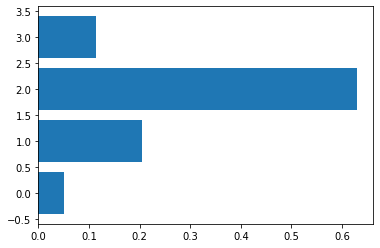

In [222]:
# find importance
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X_train.iloc[:, 1:], X_train.iloc[:, 0])
for name, score in zip(test.head(), rnd_clf.feature_importances_):
  print(f"{name} importance score: {score}")
print(list(X_train.columns))
plt.barh(range(len(rnd_clf.feature_importances_)), rnd_clf.feature_importances_)

# Most important traits are Sex, Age, and Fare

In [223]:
# Adacadabra
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X_train,Y_train)

ADA_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    4.4s finished


In [224]:
# Extra, extra, read all about it!
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsExtC.fit(X_train,Y_train)

EXTC_best = gsExtC.best_estimator_

print(gsExtC.best_score_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
Fitting 10 folds for each of 54 candidates, totalling 540 fits
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done 533 out of 540 | elapsed:   37.2s remaining:    0.4s
0.8103121098626715
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   37.4s finished


In [225]:
# Among trees
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

print(gsRFC.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   36.1s
[Parallel(n_jobs=4)]: Done 533 out of 540 | elapsed:   41.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   41.7s finished
0.8159300873907617


In [226]:
# Boost it!
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

print(gsGBC.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   14.1s
0.8092259675405742
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   26.9s finished


In [227]:
# Support me!
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

print(gsSVMC.best_score_)

Fitting 10 folds for each of 28 candidates, totalling 280 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 273 out of 280 | elapsed:   18.2s remaining:    0.4s
0.8136828963795256
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   19.8s finished


In [228]:
# 8ball will my code work?
test_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_ExtC = pd.Series(EXTC_best.predict(test), name="ExtC")
test_AdaC = pd.Series(ADA_best.predict(test), name="Ada")
test_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")

# Combine classifier results
ensemble_results = pd.concat([test_RFC, test_ExtC, test_AdaC, test_GBC, test_SVMC],axis=1)

# Expropriate!
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', EXTC_best),
('svc', SVMC_best), ('adac', ADA_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

who_Survived = pd.Series(votingC.predict(test), name="Survived")

# It is decidedly so
results = pd.concat([IDtest, who_Survived],axis=1)
results.to_csv("ensemble_titanic.csv",index=False)